https://fmriprep.readthedocs.io/en/0.5.0/sdc/estimation.html

In [16]:
import os

from bids import BIDSLayout

In [17]:
base_dir = os.path.abspath("data")
output_dir = os.path.abspath("outputs")

layout = BIDSLayout(base_dir)

In [18]:
def get_fmaps(dwi_file):
    dwi_metadata = layout.get_metadata(dwi_file)
    fmaps = []
    fmaps = layout.get_fieldmap(dwi_file, return_list=True)
    if not fmaps:
        print("No fmaps found")
    for fmap in fmaps:
        if fmap["suffix"] == "phase":
            fmap["metadata"] = {}
            fmap["metadata"]["phase1"] = layout.get_metadata(fmap["phase1"])
            fmap["metadata"]["phase2"] = layout.get_metadata(fmap["phase2"])
        else:
            fmap["metadata"] = layout.get_metadata(fmap[fmap["suffix"]])
    
    FMAP_PRIORITY = {"epi": 0, "fieldmap": 1, "phasediff": 2, "phase": 3, "syn": 4}
    
    fmaps.sort(key=lambda fmap: FMAP_PRIORITY[fmap["suffix"]])
    
    return fmaps

### Topup

In [19]:
subject_id = "NDARAJ366ZFA"
dwi_files = layout.get(subject=subject_id, datatype="dwi", suffix="dwi", extensions=[".nii", ".nii.gz"], return_type="filename")

/Users/Michael/.pyenv/versions/dwi_venv/lib/python3.7/site-packages/bids/layout/layout.py:659: UserWarning: In pybids 0.9.0, the 'extensions' filter was deprecated in favor of 'extension'. The former will stop working in 0.11.0.
  warnings.warn("In pybids 0.9.0, the 'extensions' filter was "


In [20]:
for dwi_file in dwi_files:
    dwi_metadata = layout.get_metadata(dwi_file)
    fmaps = get_fmaps(dwi_file)

In [21]:
fmap = fmaps[0]
if fmap["suffix"] == "epi":
    epi_fmaps = [(fmap_['epi'], fmap_['metadata']["PhaseEncodingDirection"]) for fmap_ in fmaps if fmap_['suffix'] == 'epi']

In [23]:
dwi_file_pe = dwi_metadata["PhaseEncodingDirection"]

usable_fieldmaps_matching_pe = []
usable_fieldmaps_opposite_pe = []

for fmap, pe_dir in epi_fmaps:
    if pe_dir == dwi_file_pe:
        usable_fieldmaps_matching_pe.append(fmap)
    elif pe_dir[0] == dwi_file_pe[0]:
        usable_fieldmaps_opposite_pe.append(fmap)
    
if not usable_fieldmaps_opposite_pe:
    print("Can't use topup")

In [24]:
from nipype.pipeline import engine as pe
from nipype.interfaces import fsl, utility as niu

def init_topup_wf(epi_fmaps):
    
    PE_DIRECTION_MAPPING = {
    "i" : "x",
    "i-": "x-",
    "j" : "y",
    "j-" : "y-",
    "k" : "z",
    "k-" : "z-"
    }
    
    epi_file = epi_fmaps[0][0]
    epi_dir = PE_DIRECTION_MAPPING[epi_fmaps[0][1]]
    altepi_file = epi_fmaps[1][0]
    altepi_dir = PE_DIRECTION_MAPPING[epi_fmaps[1][1]]
    
    wf = pe.Workflow(name="topup_wf")
        
    inputnode = pe.Node(
        niu.IdentityInterface(fields=["epi_file", "altepi_file"]),
        name="inputnode")    
    inputnode.epi_file = epi_file
    inputnode.altepi_file = altepi_file
    
    outputnode = pe.Node(
        niu.IdentityInterface(fields=["out_fmap"]),
        name="outputnode")
    
    list_merge = pe.Node(niu.Merge(numinputs=2), name="list_merge")
    
    merge = pe.Node(fsl.Merge(dimension="t"), name="mergeAPPA")
        
    topup = pe.Node(fsl.TOPUP(), name="topup")
    topup.inputs.encoding_direction = [epi_dir, altepi_dir]
    topup.inputs.readout_times = [0.05, 0.05]
    
    wf.connect(
        [
            (
                inputnode,
                list_merge,
                [("epi_file", "in1"), ("altepi_file", "in2")]
            ),
            (list_merge, merge, [("out", "in_files")]),
            (merge, topup, [("merged_file", "in_file")]),
            (topup, outputnode, [("out_field", "out_fmap")]),
        ]
    )
    
    return wf

In [25]:
topup_wf = init_topup_wf(epi_fmaps)
topup_wf.base_dir = output_dir
topup_wf.run()

190708-19:55:05,845 nipype.workflow INFO:
	 Workflow topup_wf settings: ['check', 'execution', 'logging', 'monitoring']
190708-19:55:05,931 nipype.workflow INFO:
	 Running serially.
190708-19:55:05,933 nipype.workflow INFO:
	 [Node] Setting-up "topup_wf.list_merge" in "/Users/Michael/projects/pipelines/dmripreproc/notebooks/outputs/topup_wf/list_merge".
190708-19:55:05,943 nipype.workflow INFO:
	 [Node] Running "list_merge" ("nipype.interfaces.utility.base.Merge")
190708-19:55:06,71 nipype.workflow INFO:
	 [Node] Finished "topup_wf.list_merge".
190708-19:55:06,73 nipype.workflow INFO:
	 [Node] Setting-up "topup_wf.mergeAPPA" in "/Users/Michael/projects/pipelines/dmripreproc/notebooks/outputs/topup_wf/mergeAPPA".
190708-19:55:06,80 nipype.workflow WARNING:
	 [Node] Error on "topup_wf.mergeAPPA" (/Users/Michael/projects/pipelines/dmripreproc/notebooks/outputs/topup_wf/mergeAPPA)
190708-19:55:06,86 nipype.workflow ERROR:
	 Node mergeAPPA failed to run on host Michaels-iMac.local.
190708-1

RuntimeError: Workflow did not execute cleanly. Check log for details

if using single dwi image, both dwi images or synthetic b0, must register both images before fslmerge

### Topup using dwi image

### Topup using synthetic b0

### Phasediff

In [116]:
subject_id = "CMP0178"
dwi_files = layout.get(subject=subject_id, datatype="dwi", suffix="dwi", extensions=[".nii", ".nii.gz"], return_type="filename")

In [117]:
for dwi_file in dwi_files:
    fmaps = get_fmaps(dwi_file)

In [118]:
fmap = fmaps[0]
if fmap["suffix"] == "phasediff":
    phasediff_file = fmap["phasediff"]
    phasediff_metadata = fmap["metadata"]

### Phase

In [119]:
subject_id = "ZHP0130"
dwi_files = layout.get(subject=subject_id, datatype="dwi", suffix="dwi", extensions=[".nii", ".nii.gz"], return_type="filename")

In [120]:
for dwi_file in dwi_files:
    fmaps = get_fmaps(dwi_file)

In [105]:
fmap = fmaps[0]
if fmap["suffix"] == "phase":
    phase1_file = fmap

{'phase1': {'AcquisitionMatrixPE': 64, 'AcquisitionNumber': 1, 'AcquisitionTime': '06:05:0.000000', 'BaseResolution': 64, 'BodyPartExamined': 'BRAIN', 'ConsistencyInfo': 'N4_VE11B_LATEST_20150530', 'ConversionSoftware': 'dcm2niix', 'ConversionSoftwareVersion': 'v1.0.20180622 (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0', 'DeviceSerialNumber': '66106', 'DwellTime': 1.61e-05, 'EchoTime': 0.0065, 'FlipAngle': 60, 'ImageOrientationPatientDICOM': [0.998672, 0.040619, 0.0316926, -0.0416821, 0.998565, 0.0336378], 'ImageType': ['ORIGINAL', 'PRIMARY', 'P', 'ND'], 'InPlanePhaseEncodingDirectionDICOM': 'COL', 'InstitutionAddress': 'Community_Drive_300_Manhasset_NYC_US_11030', 'InstitutionalDepartmentName': 'RADIOLOGY', 'IntendedFor': ['ses-01/dwi/sub-ZHP0130_ses-01_acq-ZHP601000_run-01_dwi.nii.gz'], 'MRAcquisitionType': '2D', 'MagneticFieldStrength': 3, 'Manufacturer': 'Siemens', 'ManufacturersModelName': 'Prisma', 'Modality': 'MR', 'PartialFourier': 1, 'PatientPosition': 'HFS', 'PercentPhaseFOV': 100,

### Fieldmap

In [21]:
def to_rads(in_file, out_file):
    from math import pi
    import nibabel as nib
    
    fmap_img = nib.load(in_file)
    fmap_data = fmap_img.get_data()
    
    fmap_range = max(abs(fmap_data.min()), fmap_data.max())
    
    fmap_data = fmap_data * (pi / fmap_range)
    
    out_img = nib.Nifti1Image(fmap_data, fmap_img.affine, fmap_img.header)
    out_img.set_data_dtype('float32')
    out_img.to_filename(out_file)
    
    return out_file, fmap_range

In [22]:
def to_hz(in_file, range_hz, out_file):
    from math import pi
    import nibabel as nib
    
    fmap_img = nib.load(in_file)
    fmap_data = fmap_img.get_data()
    
    fmap_data = fmap_data * (range_hz / pi)
    out_img = nib.Nifti1Image(fmap_data, fmap_img.affine, fmap_img.header)
    out_img.set_data_dtype('float32')
    out_img.to_filename(out_file)
    
    return out_file

In [36]:
fmap_file = "{}/sub-CMH0171/ses-01/fmap/sub-CMH0171_ses-01_run-01_fieldmap.nii.gz".format(base_dir)

out_file, fmap_range = to_rads(fmap_file, fmap_file.replace('.nii.gz', '_rad.nii.gz'))

new_out_file = to_hz(out_file, fmap_range, out_file.replace('_rad.nii.gz', '_hz.nii.gz'))

In [37]:
fmap_img = nib.load(fmap_file)
fmap_data = fmap_img.get_data()

fmap_range = max(abs(fmap_data.min()), fmap_data.max())
print(fmap_range)

2048.7444


In [38]:
fmap_img = nib.load(out_file)
fmap_data = fmap_img.get_data()

fmap_range = max(abs(fmap_data.min()), fmap_data.max())
print(fmap_range)

3.1415927


In [39]:
fmap_img = nib.load(new_out_file)
fmap_data = fmap_img.get_data()

fmap_range = max(abs(fmap_data.min()), fmap_data.max())
print(fmap_range)

2048.7446


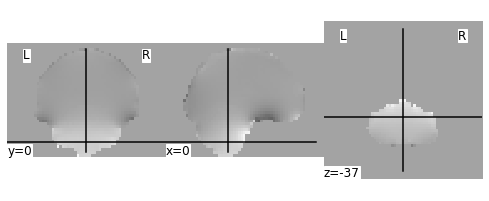

In [27]:
plot_anat(fmap_file)

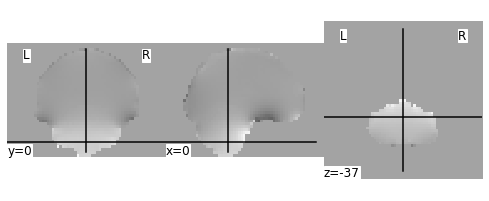

In [28]:
plot_anat(out_file)

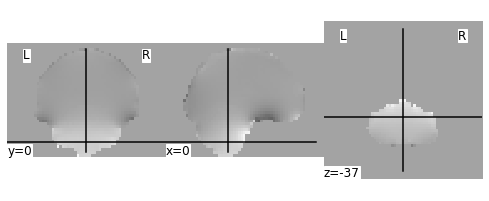

In [29]:
plot_anat(new_out_file)